In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
import pandas as pd
import os

# 원본 CSV 파일 경로
csv_file_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/trainLabels.csv"
# 이미지 파일이 있는 폴더 경로
image_folder_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/binary_img"
# 새로 저장할 CSV 파일 경로
new_csv_file_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/raw_asm_data/train_label_200.csv"

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)

# 이미지 파일 목록 가져오기
image_files = os.listdir(image_folder_path)
image_files = [os.path.splitext(file)[0] for file in image_files]  # 파일명에서 확장자 제거

# 파일명에 해당하는 행만 필터링
filtered_df = df[df['Id'].isin(image_files)]

# 새로운 CSV 파일로 저장
filtered_df.to_csv(new_csv_file_path, index=False)
"""

'\nimport pandas as pd\nimport os\n\n# 원본 CSV 파일 경로\ncsv_file_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/trainLabels.csv"\n# 이미지 파일이 있는 폴더 경로\nimage_folder_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/binary_img"\n# 새로 저장할 CSV 파일 경로\nnew_csv_file_path = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/raw_asm_data/train_label_200.csv"\n\n# CSV 파일 읽기\ndf = pd.read_csv(csv_file_path)\n\n# 이미지 파일 목록 가져오기\nimage_files = os.listdir(image_folder_path)\nimage_files = [os.path.splitext(file)[0] for file in image_files]  # 파일명에서 확장자 제거\n\n# 파일명에 해당하는 행만 필터링\nfiltered_df = df[df[\'Id\'].isin(image_files)]\n\n# 새로운 CSV 파일로 저장\nfiltered_df.to_csv(new_csv_file_path, index=False)\n'

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

df = pd.read_csv("/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/raw_asm_data/train_label_200.csv")

# 이미지 파일 경로와 클래스 레이블을 리스트로 변환
image_paths = df['Id'].tolist()
labels = df['Class'].tolist()

img_dir = "/content/drive/MyDrive/Ping!_AI악성코드분류기/microsoft/binary_img/"

# 데이터를 train, val, test 세트로 나누기
train_images, test_images, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7}
# 클래스 레이블을 변경
train_labels = [label_mapping[label] for label in train_labels]
val_labels = [label_mapping[label] for label in val_labels]
test_labels = [label_mapping[label] for label in test_labels]

# 이미지 파일 경로에 확장자 추가
train_images = [img_dir+image_path + '.png' for image_path in train_images]
val_images = [img_dir+image_path + '.png' for image_path in val_images]
test_images = [img_dir+image_path + '.png' for image_path in test_images]

# 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# 데이터 전처리 함수 정의
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, (256, 256))
    image = image / 255.0
    return image, label

# 데이터셋에 전처리 함수 적용
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 데이터셋을 셔플하고 배치로 나누기
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Class: 0


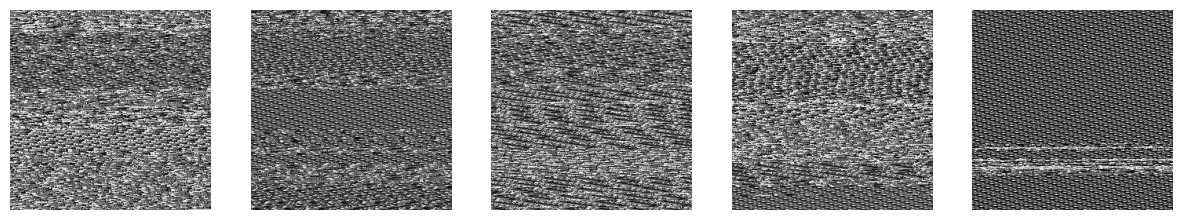

Class: 1


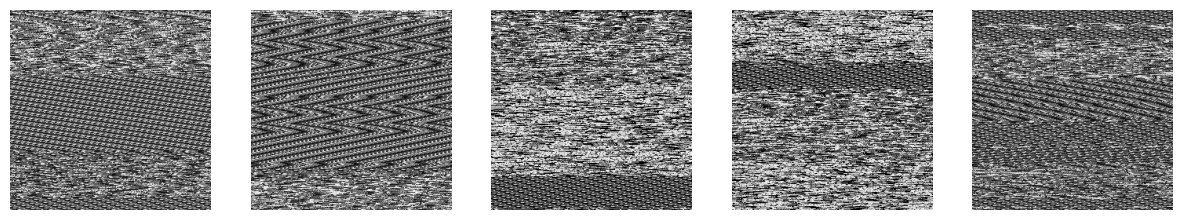

Class: 2


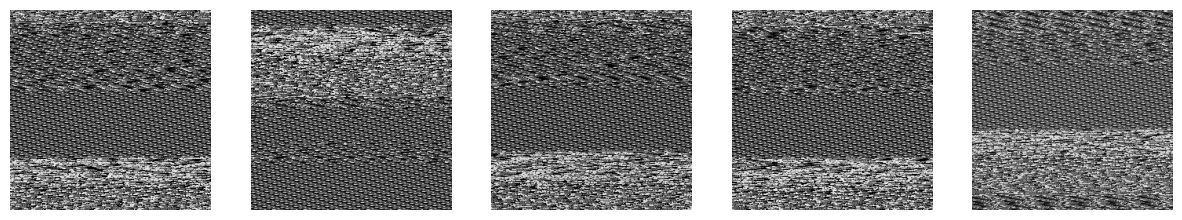

Class: 3


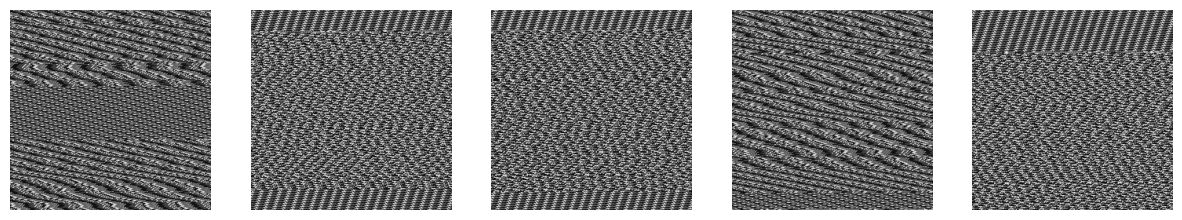

Class: 4


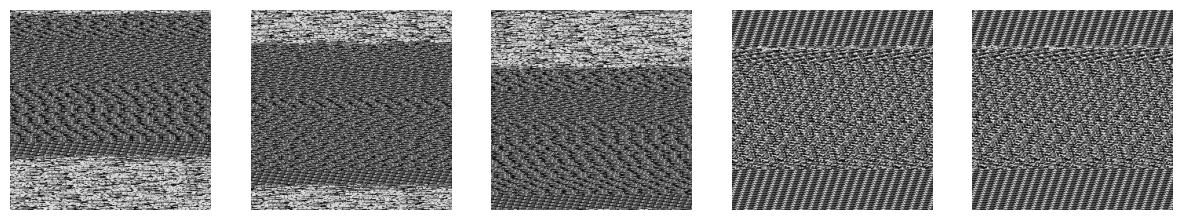

Class: 5


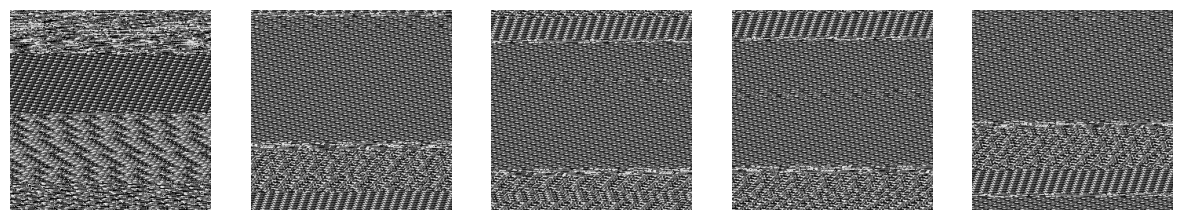

Class: 6


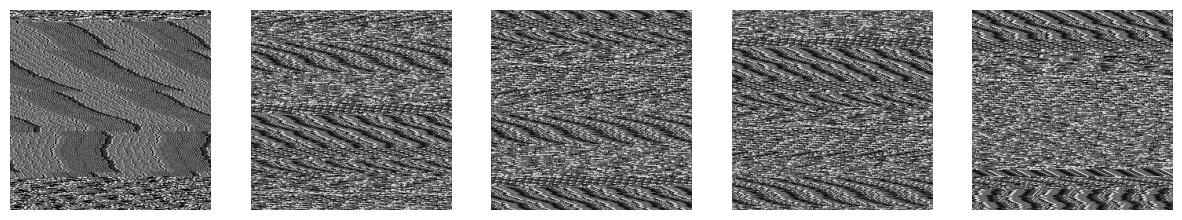

Class: 7


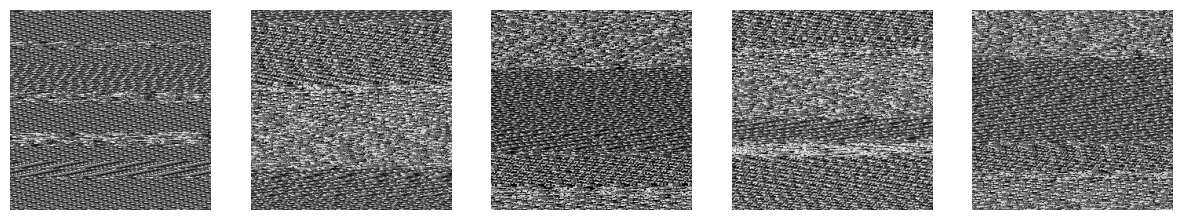

In [ ]:
# 각 클래스별로 5개씩 이미지 시각화
import matplotlib.pyplot as plt

num_samples_per_class = 5
class_datasets = {label: [] for label in set(train_labels)}

for image, label in train_dataset:
    for i in range(batch_size):
        class_label = label[i].numpy()
        class_datasets[class_label].append(image[i])

for label, images in class_datasets.items():
    print(f"Class:", label)
    fig, axes = plt.subplots(1, num_samples_per_class, figsize=(15, 3))
    for i in range(num_samples_per_class):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 모델 학습
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 30, 30, 64)       

In [ ]:
# EarlyStopping 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 [==============================] - 105s 3s/step - loss: 2.0845 - accuracy: 0.1045 - val_loss: 2.0761 - val_accuracy: 0.1289
Epoch 2/50
32/32 [==============================] - 100s 3s/step - loss: 2.0728 - accuracy: 0.1406 - val_loss: 2.0421 - val_accuracy: 0.2148
Epoch 3/50
32/32 [==============================] - 99s 3s/step - loss: 1.9924 - accuracy: 0.2002 - val_loss: 1.9040 - val_accuracy: 0.3438
Epoch 4/50
32/32 [==============================] - 95s 3s/step - loss: 1.8313 - accuracy: 0.3105 - val_loss: 1.7042 - val_accuracy: 0.3477
Epoch 5/50
32/32 [==============================] - 99s 3s/step - loss: 1.6294 - accuracy: 0.3828 - val_loss: 1.5360 - val_accuracy: 0.4336
Epoch 6/50
32/32 [==============================] - 99s 3s/step - loss: 1.5047 - accuracy: 0.4385 - val_loss: 1.3735 - val_accuracy: 0.5117
Epoch 7/50
32/32 [==============================] - 95s 3s/step - loss: 1.4671 - accuracy: 0.4600 - val_loss: 1.3639 - val_accuracy: 0.4727
Epoch 8/50
32/32 [

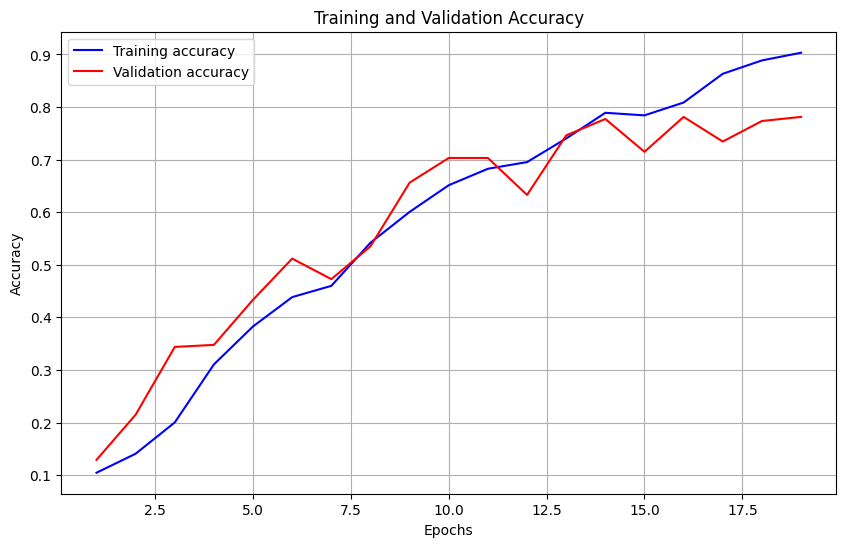

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과(history)로부터 정확도(accuracy)와 검증 정확도(validation accuracy)를 가져옴
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 에포크 수 생성
epochs = range(1, len(train_accuracy) + 1)

# 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 테스트 데이터셋으로 모델 평가
loss, accuracy = model.evaluate(test_dataset)
print(f"손실: {loss}")
print(f"정확도: {accuracy}")
#channel3 batch32 epoch10 정확도: 0.5843750238418579
#channel1 batch32 epoch10 정확도: 0.699999988079071
#channel1 batch32 epoch13 정확도: 0.706250011920929
#dropout epoch를 많이 높게 주면 정확도 높아질수도 있지만 20정도까진 시간도 너무 오래걸리고 과소적합.
#32 64 128 channel1 batch32 epoch50(earlystopping patience5)  정확도: 0.609375
#32 32 128 정확도: 0.612500011920929
#32 32 64 128 정확도: 정확도: 0.6875
#32 32 64 128 patience3 정확도: 0.6781250238418579




10/10 [==============================] - 10s 1s/step - loss: 0.9997 - accuracy: 0.6875
손실: 0.999734103679657
정확도: 0.6875


In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [ ]:
model2.fit(x=train_dataset,
    validation_data=val_dataset,
    epochs=16)

Epoch 1/16
32/32 [==============================] - 401s 5s/step - loss: 2.0912 - accuracy: 0.1133 - val_loss: 2.0749 - val_accuracy: 0.1484
Epoch 2/16
32/32 [==============================] - 123s 4s/step - loss: 2.0655 - accuracy: 0.1826 - val_loss: 2.0006 - val_accuracy: 0.2383
Epoch 3/16
32/32 [==============================] - 126s 4s/step - loss: 1.9488 - accuracy: 0.2090 - val_loss: 1.9000 - val_accuracy: 0.1641
Epoch 4/16
32/32 [==============================] - 125s 4s/step - loss: 1.8311 - accuracy: 0.2705 - val_loss: 1.8204 - val_accuracy: 0.2031
Epoch 5/16
32/32 [==============================] - 133s 4s/step - loss: 1.7318 - accuracy: 0.3320 - val_loss: 1.5802 - val_accuracy: 0.3633
Epoch 6/16
32/32 [==============================] - 123s 4s/step - loss: 1.5582 - accuracy: 0.4062 - val_loss: 1.4574 - val_accuracy: 0.4102
Epoch 7/16
32/32 [==============================] - 123s 4s/step - loss: 1.4046 - accuracy: 0.5000 - val_loss: 1.3327 - val_accuracy: 0.5625
Epoch 8/16
32

In [ ]:
loss, accuracy = model2.evaluate(test_dataset)
print(f"손실: {loss}")
print(f"정확도: {accuracy}")

10/10 [==============================] - 70s 7s/step - loss: 1.0068 - accuracy: 0.6938
손실: 1.0067603588104248
정확도: 0.6937500238418579


In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 모델 학습
model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 64)       

In [ ]:
# EarlyStopping 콜백 정의
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model3.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
32/32 [==============================] - 121s 4s/step - loss: 2.0957 - accuracy: 0.1289 - val_loss: 2.0770 - val_accuracy: 0.1758
Epoch 2/50
32/32 [==============================] - 119s 4s/step - loss: 2.0724 - accuracy: 0.1514 - val_loss: 2.0674 - val_accuracy: 0.1484
Epoch 3/50
32/32 [==============================] - 116s 3s/step - loss: 2.0851 - accuracy: 0.1396 - val_loss: 2.0761 - val_accuracy: 0.1523
Epoch 4/50
32/32 [==============================] - 116s 4s/step - loss: 2.0749 - accuracy: 0.1533 - val_loss: 2.0512 - val_accuracy: 0.1953
Epoch 5/50
32/32 [==============================] - 116s 4s/step - loss: 2.0242 - accuracy: 0.1924 - val_loss: 2.0293 - val_accuracy: 0.2148
Epoch 6/50
32/32 [==============================] - 112s 3s/step - loss: 1.8593 - accuracy: 0.2715 - val_loss: 1.8374 - val_accuracy: 0.2773
Epoch 7/50
32/32 [==============================] - 116s 3s/step - loss: 1.8131 - accuracy: 0.3096 - val_loss: 1.6057 - val_accuracy: 0.4531
Epoch 8/50
32

In [ ]:
loss, accuracy = model2.evaluate(test_dataset)
print(f"손실: {loss}")
print(f"정확도: {accuracy}")

10/10 [==============================] - 10s 925ms/step - loss: 1.0068 - accuracy: 0.6938
손실: 1.0067603588104248
정확도: 0.6937500238418579


In [ ]:
import matplotlib.pyplot as plt

# 학습 결과(history)로부터 정확도(accuracy)와 검증 정확도(validation accuracy)를 가져옴
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 에포크 수 생성
epochs = range(1, len(train_accuracy) + 1)

# 정확도 시각화
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
